In [21]:
import yaml

In [22]:
# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [23]:
if menu['all_stats']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from io import StringIO
    import requests
    from sklearn.preprocessing import MinMaxScaler
    from shapely.geometry import shape
    from shapely.ops import unary_union
    import pint
    import folium
    from pathlib import Path
    import matplotlib.pyplot as plt
    import requests
    import re
    import rasterio
    from rasterio.mask import mask
    from shapely.geometry import Point
    from fiona.crs import from_epsg
    from nbconvert import MarkdownExporter
    import nbformat
    import base64
    import pickle
    import plotly.graph_objects as go
    import osmnx as ox
    from shapely.geometry import box
    from matplotlib.lines import Line2D
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
    import contextily as cx
    import matplotlib.patheffects as pe
    from sklearn.preprocessing import robust_scale
    from sklearn.cluster import AgglomerativeClustering
    from rasterio.plot import show
    import plotly.express as px
    from shapely.geometry import shape
    from scipy.stats import linregress
    from rasterio.warp import reproject, Resampling
    from shapely.ops import transform
    from functools import partial
    import pyproj
    import warnings
    import plotly.offline as pyo
    #from pysal import lib
    #from pysal.explore import esda
    

##Text begins

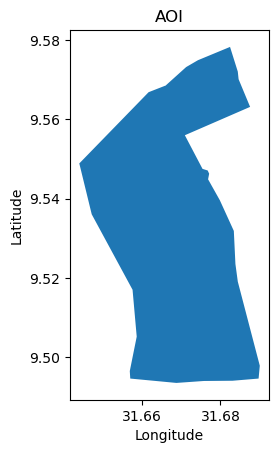

The first highest landcover value is Grassland with 80.37% of the total land area
The second highest landcover value is Built-up with 8.41% of the total land area
The third highest landcover value is Shrubland with 6.54% of the total land area
       Bin  Count    percent Percent  Elevation
0  386-388     57   0.186579      0%        386
1  388-390    344   1.126023      1%        388
2  390-391  12970  42.454992     42%        390
3  391-393  17176  56.222586     56%        391
4  393-395      3   0.009820      0%        393


Highest percentage entry for Elevation is 56% in the bin range 391-393
Merged pluvial data saved as mnt/city-directories/02-process-output/malakal_merged_pluvial_data_utm.tif
Merged fluvial data saved as mnt/city-directories/02-process-output/malakal_merged_fluvial_data_utm.tif
Total length of roads intersecting fluvial data: 0.00 km
Percentage of roads intersecting fluvial data: 0.0000%
city name: malakal
country name:south_sudan


/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_10723/3389882479.py:39: UserWarning:

Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [24]:
# SET UP ##############################################


# load global inputs, such as data sources that generally remain the same across scans

with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)
# run scan assembly and toolbox
%run 'scan_assembly.ipynb'
%run 'toolbox.ipynb'

# load city inputs files, to be updated for each city scan
with open("mnt/city-directories/01-user-input/city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)
city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
print(f"city name: {city}")
print(f"country name:{country}")
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry
# Define output folder ---------
output_folder = Path('mnt/city-directories/02-process-output')
render_folder = Path('mnt/city-directories/03-render-output')
if not os.path.exists(output_folder):
    os.mkdir(output_folder)



##City Subdistricts available?

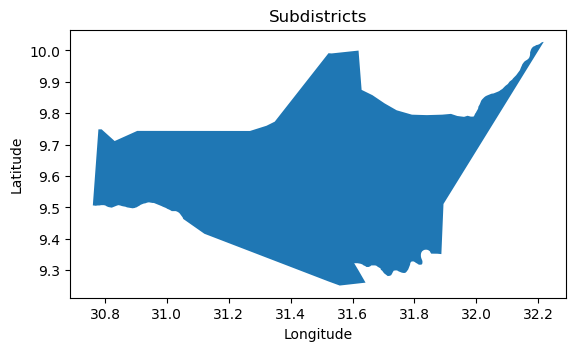

city subdistricts are larger than malakal: Not available


In [25]:
#Intersect subdistricts to AOI - Is this necessary? We need ward level files
clip_extent = features.geometry.total_bounds
clip_box = box(*clip_extent)
# transform the input shp to correct prj (epsg 4326)
lowest_admin_file = gpd.read_file(city_inputs['lowest_admin_shp']).to_crs(epsg = 4326) 
lowest_admin_country = lowest_admin_file.geometry
lower_admin_level = lowest_admin_country.cx[clip_box.bounds[0]:clip_box.bounds[2], clip_box.bounds[1]:clip_box.bounds[3]]
#plot check
fig, ax = plt.subplots()
lower_admin_level.plot(ax=ax)
plt.title('Subdistricts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

print(f"city subdistricts are larger than {city}: Not available")

In [26]:
#Standard Units
def enumerate_items(source):
    print("/n")
    for ele in enumerate(source): 
        print(ele)

def list_df_columns(df):
    field_list = list(df)
    enumerate_items(field_list)
    return field_list

def percentage_formatter(x, pos):
    return f'{x * 100 :,.0f}'

def millions_formatter(x, pos):
    return f'{x / 1000000 :,.0f}'


def hundred_thousand_formatter(x, pos):
    return f'{x / 100000 :,.0f}'

def billions_formatter(x, pos):
    return f'{x / 1000000000 :,.0f}'


##Lowest admin level available?

In [27]:
def get_lowest_admin_level():
    try:
        # Reset index of features DataFrame
        vector = features.reset_index()
        
        # Set the CRS to EPSG 4326 (WGS84)
        crs = 4326
        
        # Define OSM admin layers tags
        tags = {"boundary": "administrative"}
        
        # Get the bounding box of the features
        minx, miny, maxx, maxy = vector.to_crs(epsg=4326).total_bounds
        
        # Retrieve OSM geometries within the bounding box with the specified tags
        all_admin_layers = ox.geometries.geometries_from_bbox(miny, maxy, minx, maxx, tags)
        
        # Get the lowest admin level 
        lowest_admin_level = all_admin_layers["admin_level"].mode()[0]
        warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS")
        # Filter OSM geometries to only include the lowest admin level
        vector_gdf = all_admin_layers[all_admin_layers['admin_level'] == lowest_admin_level]
        
        # Define the name for the lowest admin level
        lowest_admin_level_name = "Settlement"
        
        # Clip the OSM geometries using the features geometry
        sub_city_gdf = gpd.clip(vector_gdf.to_crs(crs), vector.to_crs(crs))

        # Calculate the area of the geometries before clipping
        vector_gdf.loc[:, "pre_clip_area"] = vector_gdf['geometry'].area

        # Calculate the area of the clipped geometries
        sub_city_gdf.loc[:, "post_clip_area"] = sub_city_gdf['geometry'].area

        # Calculate the percentage of area retained after clipping
        sub_city_gdf.loc[:, "pct_clip_area"] = (sub_city_gdf["post_clip_area"] / sub_city_gdf["pre_clip_area"]) * 100


        
        # Filter out geometries with less than 50% area retained after clipping
        sub_city_gdf = sub_city_gdf[sub_city_gdf['pct_clip_area'] > 50]
        
        # Fill English names with native names
        sub_city_gdf['name:en'] = sub_city_gdf['name:en'].str.strip().replace('', np.nan).fillna(sub_city_gdf['name'])
        
        # Convert the clipped OSM geometries to the desired CRS
        sub_city_gdf = sub_city_gdf.to_crs(crs)
        
    
        # Plot your GeoDataFrame
        ax = sub_city_gdf.plot(alpha=0.8,
                               facecolor='none',
                               edgecolor='black',
                               label=f"{city}",
                               missing_kwds={"color": "white", "edgecolor": "black", "label": "none"},
                               zorder=5)
        
        # Show plot
        plt.show()
        
        print("Yes, it is available")
    except Exception as e:
        print("Not available")
        print(e)
    warnings.filterwarnings("ignore")
    
get_lowest_admin_level() 

      

/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_10723/1472612019.py:16: UserWarning:

The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.



Not available
'pre_clip_area'


/Users/ipshitakarmakar/mambaforge/envs/geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Area of the city

In [28]:
area = calculate_aoi_area(features)
print(f"Area of the city of {city} is {area}")

Area of the city of malakal is 23.146904876625676 kilometer ** 2


Koppen Climate

In [29]:
get_koeppen_classification()

Köppen climate classification:  BSh (See https://en.wikipedia.org/wiki/Köppen_climate_classification for classes)


array([' BSh'], dtype=object)

Population distribution by age and sex

In [30]:
age_stats()

under5: 25.14%
youth (15-24): 46.14%
working_age (15-64): 57.57%
elderly (60+): 8.52%
reproductive_age, percent of women (15-50): 51.41%
sex_ratio: -98.02 males to 100 females


In [31]:
#Text option 1 - Delta and Range

def find_highest_lowest_pixel_value_path(raster_path):
    try:
        with rasterio.open(raster_path) as src:
            # Read the raster data
            raster_data = src.read(1)

            # Find the highest and lowest pixel values
            highest_value = round(raster_data.max(), 2)
            lowest_value = round(raster_data[raster_data > 0].min(), 2)  # Exclude zero values
            
            # Print the statement with reduced digits after the decimal point
            print(f"Values range from {lowest_value:.2f} units to {highest_value:.2f} units")

            return highest_value, lowest_value
        
    except Exception as e:
        print("Error:", e)
        return None, None

In [32]:
#Text option 1 - Delta and Range
def find_highest_lowest_pixel_value(raster_data):
    try:
        # Flatten the array, excluding NaN values
        valid_values = raster_data[~np.isnan(raster_data)].flatten()
        
        # Find the highest and lowest pixel values
        highest_value = round(np.nanmax(valid_values), 2)
        lowest_value = round(np.nanmin(valid_values), 2)
        
        # Print the statement with reduced digits after the decimal point
        print(f"Values range from {lowest_value:.2f} units to {highest_value:.2f} units")

        return highest_value, lowest_value
    
    except Exception as e:
        print("Error:", e)
        return None, None



In [33]:
#Text Option 2 - Clustering 
def create_raster_clusters(raster_data, n_clusters=5):
    try:
        if isinstance(raster_data, str):
            with rasterio.open(raster_data) as src:
                raster_data = src.read(1)
                transform = src.transform
        else:
            pass

        flat_data = raster_data.flatten().reshape(-1, 1)

        clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(flat_data)

        cluster_labels = clustering.labels_.reshape(raster_data.shape)

        return cluster_labels

    except Exception as e:
        print("Error:", e)
        return None

#example usage
raster_path = os.path.join(output_folder, city + '_population.tif')
create_raster_clusters(raster_path)
cluster_labels = create_raster_clusters(raster_path)


def plot_cluster_labels_plotly(cluster_labels):
    fig = px.imshow(cluster_labels, color_continuous_scale='viridis')
    fig.update_layout(
        xaxis_title='Column Index',
        yaxis_title='Row Index'
    )
    fig.show()




In [34]:
def get_raster_cluster_labels(raster_path, n_clusters=5):
    try:
        # Open the raster file
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)
            transform = src.transform

        # Flatten the raster data to a 1D array
        flat_data = raster_data.flatten().reshape(-1, 1)

        # Perform agglomerative clustering
        clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(flat_data)

        # Reshape the cluster labels to match the original raster dimensions
        cluster_labels = clustering.labels_.reshape(raster_data.shape)

        return cluster_labels, transform

    except Exception as e:
        print("Error:", e)
        return None, None


# Example usage:
raster_path = os.path.join(output_folder, city + '_population.tif')
cluster_labels, transform = get_raster_cluster_labels(raster_path)

In [35]:
from rasterio.crs import CRS

# Define the Affine transformation matrix
affine_transform = transform

# Define the EPSG code for the CRS
epsg_code = 4326 

# Create a CRS object
crs = CRS.from_epsg(epsg_code)

In [36]:
def get_cluster_boundaries(cluster_labels, transform):
    # Get unique cluster labels
    unique_labels = np.unique(cluster_labels)

    # Initialize a list to store cluster boundary polygons
    cluster_polygons = []

    # Iterate over each unique cluster label
    for label in unique_labels:
        # Create a mask for pixels with the current label
        mask = cluster_labels == label

        # Get the indices of non-zero elements in the mask
        nonzero_indices = np.argwhere(mask)

        # Calculate the bounding box of the cluster
        min_row, min_col = np.min(nonzero_indices, axis=0)
        max_row, max_col = np.max(nonzero_indices, axis=0)

        # Calculate the bounding box coordinates
        minx, miny = transform * (min_col, min_row)
        maxx, maxy = transform * (max_col, max_row)

        # Create the bounding box polygon
        geom = box(minx, miny, maxx, maxy)

        # Transform the polygon to the desired CRS
        geom = gpd.GeoSeries(geom, crs=crs).to_crs(crs)

        # Add the polygon to the list
        cluster_polygons.append(geom[0])  # Take the first element

    # Combine all polygons into a GeoDataFrame
    cluster_gdf = gpd.GeoDataFrame({'cluster_label': unique_labels}, geometry=cluster_polygons, crs=crs)

    return cluster_gdf

cluster_gdf = get_cluster_boundaries(cluster_labels, transform)

In [37]:
def describe_cluster_location(cluster_gdf, aoi_file):
    # Get the centroid of the city
    city_centroid = shape(aoi_file.geometry.centroid.iloc[0])
        
    # Get the centroid of the cluster with the highest value
    highest_cluster = cluster_gdf[cluster_gdf['cluster_label'] == cluster_gdf['cluster_label'].max()]['geometry'].centroid.values[0]
    # Get the centroid of the cluster with the lowest value
    lowest_cluster = cluster_gdf[cluster_gdf['cluster_label'] == cluster_gdf['cluster_label'].min()]['geometry'].centroid.values[0]
    
    # Determine the location of the clusters
    highest_location = "north" if highest_cluster.y > city_centroid.y else "south"
    lowest_location = "north" if lowest_cluster.y > city_centroid.y else "south"
    
    if highest_cluster.x > city_centroid.x:
        highest_location += " east"
    elif highest_cluster.x < city_centroid.x:
        highest_location += " west"
        
    if lowest_cluster.x > city_centroid.x:
        lowest_location += " east"
    elif lowest_cluster.x < city_centroid.x:
        lowest_location += " west"
        
    # Check if the centroids are within a range of the city centroid 
    center_range = 0.2  
    center_clusters = cluster_gdf[cluster_gdf['geometry'].apply(lambda geom: abs(geom.centroid.x - city_centroid.x) < center_range and abs(geom.centroid.y - city_centroid.y) < center_range)]
    
    if len(center_clusters) > 0:
        if cluster_gdf['cluster_label'].max() == center_clusters['cluster_label'].max():
            highest_location = "center"
        else:
            center_location = "center"
    
    # Print statements describing cluster locations
    print(f"The cluster with the highest value is located in the {highest_location} of the city.")
    print(f"The cluster with the lowest value is located in the {lowest_location} of the city.")





In [38]:
#Text option 4 - OLS
#Bit tricky but might be fun
if menu['summer_lst']:  
    summer_path = os.path.join(output_folder, city + '_summer.tif')
    with rasterio.open(summer_path) as src:
        summer_data = src.read(1)
        summer_data = np.nan_to_num(summer_data, nan=0) 
        transform = src.transform
def pixelwise_regression(pop_path, summer_path):
    try:
        # Open population raster
        with rasterio.open(pop_path) as pop_src:
            pop_data = pop_src.read(1)
            pop_profile = pop_src.profile

        # Open summer LST raster and reproject to match population raster
        with rasterio.open(summer_path) as summer_src:
            summer_data = summer_src.read(1)
            summer_profile = summer_src.profile

            # Reproject summer LST raster to match population raster
            pop_data_resampled = np.zeros_like(summer_data)
            reproject(
                source=pop_data,
                destination=pop_data_resampled,
                src_transform=pop_src.transform,
                src_crs=pop_src.crs,
                dst_transform=summer_src.transform,
                dst_crs=summer_src.crs,
                resampling=Resampling.bilinear
            )

        # Flatten the arrays
        summer_flat = summer_data.flatten()
        pop_flat = pop_data_resampled.flatten()

        # Perform pixel-wise linear regression
        slope, intercept, r_value, p_value, std_err = linregress(pop_flat, summer_flat)

        # Check if p-value is significant
        if np.isnan(p_value):
            print("Regression is not significant. Results may not be reliable.")

        return slope, intercept, r_value, p_value, std_err

    except Exception as e:
        print("Error:", e)
        return None, None, None, None, None
        



Population Density

In [39]:
#Iterate
if menu['population']:  
    pop_path = os.path.join(output_folder, city + '_population.tif')
    with rasterio.open(pop_path) as src:
        pop_data = src.read(1)
        transform = src.transform  

    create_raster_clusters(pop_data, n_clusters=5)
    plot_cluster_labels_plotly(cluster_labels)
    if cluster_labels is not None:
        print("Cluster labels shape:", cluster_labels.shape)
        pop_cluster_gdf = get_cluster_boundaries(cluster_labels, transform)
        pop_cluster = describe_cluster_location(pop_cluster_gdf, aoi_file)
        pop_cluster
    find_highest_lowest_pixel_value_path(pop_path)
    pixelwise_regression(pop_path, summer_path)

Cluster labels shape: (103, 56)
The cluster with the highest value is located in the center of the city.
The cluster with the lowest value is located in the north west of the city.
Values range from 56.68 units to 137.16 units


Economic Activity

In [40]:
if menu['raster_processing']:  
    rad_path = os.path.join(output_folder, city + '_avg_rad_sum.tif')
    with rasterio.open(rad_path) as src:
        rad_data = src.read(1)
        rad_data[rad_data == -9999] = np.nan
        rad_data = np.nan_to_num(rad_data, nan=0) 
        
        transform = src.transform
    rad_cluster_labels = create_raster_clusters(rad_data, n_clusters=5)
    plot_cluster_labels_plotly(rad_cluster_labels)
    if cluster_labels is not None:
        print("Cluster labels shape:", rad_cluster_labels.shape)
        rad_cluster_gdf = get_cluster_boundaries(rad_cluster_labels, transform)
        rad_cluster = describe_cluster_location(rad_cluster_gdf, aoi_file)
        rad_cluster
    find_highest_lowest_pixel_value(rad_data)

Cluster labels shape: (95, 53)
The cluster with the highest value is located in the center of the city.
The cluster with the lowest value is located in the north west of the city.
Values range from 0.00 units to 3215.77 units


Change in Economic Activity 

In [41]:
if menu['raster_processing']:  
    linfit_path = os.path.join(output_folder, city + '_linfit.tif')
    with rasterio.open(linfit_path) as src:
        linfit_data = src.read(1)
        linfit_data[linfit_data == -9999] = np.nan
        linfit_data = np.nan_to_num(linfit_data, nan=0) 
        transform = src.transform
    linfit_cluster_labels = create_raster_clusters(linfit_data, n_clusters=5)
    plot_cluster_labels_plotly(linfit_cluster_labels)
    if cluster_labels is not None:
        print("Cluster labels shape:", linfit_cluster_labels.shape)
        linfit_cluster_gdf = get_cluster_boundaries(linfit_cluster_labels, transform)
        linfit_cluster = describe_cluster_location(linfit_cluster_gdf, aoi_file)
        linfit_cluster
    find_highest_lowest_pixel_value(linfit_data)

Cluster labels shape: (95, 53)
The cluster with the highest value is located in the center of the city.
The cluster with the lowest value is located in the north west of the city.
Values range from -0.84 units to 1.50 units


Urban Extent and Change

In [42]:
wsf_stats()

The city's built-up area grew from 15.01 sq. km in 1985 to 15.43 in 2015 for 2.83% growth


Land Cover

In [43]:
lc_stats()

The first highest landcover value is Grassland with 80.37% of the total land area
The second highest landcover value is Built-up with 8.41% of the total land area
The third highest landcover value is Shrubland with 6.54% of the total land area


Photovoltaic Power Potential

In [44]:
extract_monthly_stats()

Seasonality is low to moderate, making solar energy available in only some of the months


Land Surface Temperature

In [45]:

if menu['summer_lst']:  
    summer_path = os.path.join(output_folder, city + '_summer.tif')
    with rasterio.open(summer_path) as src:
        summer_data = src.read(1)
        summer_data[summer_data == -9999] = np.nan
        summer_data = np.nan_to_num(summer_data, nan=0) 
        # Filter out zeros and NaNs before finding the lowest value
        nonzero_values = summer_data[(summer_data != 0) & (~np.isnan(summer_data))]

    if len(nonzero_values) > 0:
        lowest_value = np.min(nonzero_values)
        min_value = np.min(nonzero_values)
        max_value = np.max(nonzero_values)
        print(f"Values range from {min_value:.2f} to {max_value:.2f}")
    else:
        print("There are no non-zero values in the summer data.")


Values range from 34.83 to 50.36


Green Spaces

In [46]:
if menu['green']:  
    NDVI_path = os.path.join(output_folder, city + '_NDVI_Annual.tif')
    with rasterio.open(NDVI_path) as src:
        NDVI_data = src.read(1)
        NDVI_data = np.nan_to_num(NDVI_data, nan=0) 
    find_highest_lowest_pixel_value(NDVI_data)

Values range from -0.07 units to 0.51 units


Elevation

In [47]:
elev_stats()

       Bin  Count    percent Percent  Elevation
0  386-388     57   0.186579      0%        386
1  388-390    344   1.126023      1%        388
2  390-391  12970  42.454992     42%        390
3  391-393  17176  56.222586     56%        391
4  393-395      3   0.009820      0%        393


Highest percentage entry for Elevation is 56% in the bin range 391-393


Slope

In [103]:
if menu['slope']:  
    slope_path = os.path.join(output_folder, city + '_slope.tif')
    with rasterio.open(slope_path) as src:
        slope_data = src.read(1)
        slope_data[slope_data == -9999] = np.nan
        slope_data = np.nan_to_num(slope_data, nan=0) 
        transform = src.transform
    #slope_cluster_labels = create_raster_clusters(slope_data, n_clusters=5)
    #plot_cluster_labels_plotly(slope_cluster_labels)
    #if cluster_labels is not None:
        #print("Cluster labels shape:", slope_cluster_labels.shape)
        #slope_cluster_gdf = get_cluster_boundaries(slope_cluster_labels, transform)
        #slope_cluster = describe_cluster_location(slope_cluster_gdf, aoi_file)
        #slope_cluster
    find_highest_lowest_pixel_value(slope_data)

Values range from 0.00 units to 13.98 units


In [48]:
slope_stats()

Highest percentage entry for Slope is 100% in the bin range 0-2


NDMI

In [105]:
if menu['ndmi']:  
    NDMI_path = os.path.join(output_folder, city + '_NDMI_Annual.tif')
    with rasterio.open(NDMI_path) as src:
        NDMI_data = src.read(1)
        NDMI_data = np.nan_to_num(NDMI_data, nan=0) 
    find_highest_lowest_pixel_value(NDMI_data)

Values range from -0.25 units to 0.27 units


Flooding 

Pluvial and OSM

In [106]:
get_pu_am()
get_pu_roads()

0 of 1 (0.00%) health are located in a riverine flood risk zone with a minimum depth of 15 cm.


0 of 2 (0.00%) police are located in a riverine flood risk zone with a minimum depth of 15 cm.
Fire stations do not exist
2 of 24 (8.33%) schools are located in a riverine flood risk zone with a minimum depth of 15 cm.
Statistics saved to mnt/city-directories/02-process-output/pu_osmpt.xlsx
Total length of highways intersecting pluvial data: 0.18 km
Percentage of highways intersecting pluvial data: 0.0769%


Pluvial Flooding and WSF

In [107]:
stats_by_year = get_pu_wsf()
if stats_by_year is not None:
    years = list(stats_by_year.keys())
    areas = list(stats_by_year.values())

    # Filter years for plotting
    years_to_plot = [1986, 1995, 2005, 2015]
    areas_to_plot = [stats_by_year.get(year, np.nan) for year in years_to_plot]

    # Matplotlib plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(years_to_plot, areas_to_plot, marker='o', linestyle='-')
    plt.title('Flooded Area from 1986 to 2015')
    plt.xlabel('Year')
    plt.ylabel('Area (square units)')
    plt.grid(True)
    plt.tight_layout()
    render_path = os.path.join(render_folder, f"{city}_pu_wsf.png")
    plt.savefig(render_path)
    plt.close()
    print(f"PNG saved to {render_path}")

    # Plotly plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=years_to_plot, y=areas_to_plot, mode='lines+markers', name='Flooded Area'))
    fig.update_layout(title='Flooded Area from 1986 to 2015',
                      xaxis_title='Year',
                      yaxis_title='Area (square units)')
    fig.show()
    fig.write_html(render_path.replace('.png', '.html'), full_html=False, include_plotlyjs='cdn')

    # Calculate 2015 text
    total_built_up_area = sum(stats_by_year.values())
    flooded_area_2015 = stats_by_year.get(2015, 0)
    if total_built_up_area != 0:
        percentage_2015 = (flooded_area_2015 / total_built_up_area) * 100
        print(f"In 2015, {flooded_area_2015:.2f} sq.m of the city’s built-up area ({percentage_2015:.2f}%) was exposed to surface water flooding.")
    else:
        print("The city is not exposed to surface water flooding.")
else:
    print("No areas calculated.")



PNG saved to mnt/city-directories/03-render-output/wau_pu_wsf.png


In 2015, 23533.40 sq.m of the city’s built-up area (0.74%) was exposed to surface water flooding.


Pluvial and Population

In [108]:
get_pu_pop_norm()

60th Percentile of Population Data (excluding zeros): 25.681974411010742
1.60% of densely populated areas are located within the rainwater flood risk zone with a minimum depth of 15 cm
Result saved to mnt/city-directories/02-process-output/pu_pop_area.csv


Fluvial and OSM

In [109]:
get_fu_am()
get_fu_roads()

0 of 1 (0.00%) health are located in a riverine flood risk zone with a minimum depth of 15 cm.
0 of 2 (0.00%) police are located in a riverine flood risk zone with a minimum depth of 15 cm.
Fire stations do not exist
1 of 24 (4.17%) schools are located in a riverine flood risk zone with a minimum depth of 15 cm.
Statistics saved to mnt/city-directories/02-process-output/fu_osmpt.xlsx
Total length of roads intersecting fluvial data: 0.19 km
Percentage of roads intersecting fluvial data: 0.0818%


Fluvial and WSF

In [74]:
stats_by_year = get_fu_wsf()
if stats_by_year is not None:
    years = list(stats_by_year.keys())
    areas = list(stats_by_year.values())

    # Filter years for plotting
    years_to_plot = [1986, 1995, 2005, 2015]
    areas_to_plot = [stats_by_year.get(year, np.nan) for year in years_to_plot]

    # Matplotlib plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(years_to_plot, areas_to_plot, marker='o', linestyle='-')
    plt.title('Flooded Area from 1986 to 2015')
    plt.xlabel('Year')
    plt.ylabel('Area (square units)')
    plt.grid(True)
    plt.tight_layout()
    render_path = os.path.join(render_folder, f"{city}_fu_wsf.png")
    plt.savefig(render_path)
    plt.close()
    print(f"PNG saved to {render_path}")

    # Plotly plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=years_to_plot, y=areas_to_plot, mode='lines+markers', name='Flooded Area'))
    fig.update_layout(title='Flooded Area from 1986 to 2015',
                      xaxis_title='Year',
                      yaxis_title='Area (square units)')
    fig.show()
    fig.write_html(render_path.replace('.png', '.html'), full_html=False, include_plotlyjs='cdn')

    # Calculate 2015 text
    total_built_up_area = sum(stats_by_year.values())
    flooded_area_2015 = stats_by_year.get(2015, 0)
    if total_built_up_area != 0:
        percentage_2015 = (flooded_area_2015 / total_built_up_area) * 100
        print(f"In 2015, {flooded_area_2015:.2f} sq.m of the city’s built-up area ({percentage_2015:.2f}%) was exposed to river flooding.")
    else:
        print("The city is not exposed to river flooding.")
else:
    print("No areas calculated.")




PNG saved to mnt/city-directories/03-render-output/fu_wsf.png


In 2015, 12237.37 sq.m of the city’s built-up area (0.40%) was exposed to river flooding.


Fluvial and Population

In [75]:
get_fu_pop_norm()

60th Percentile of Population Data (excluding zeros): 25.681974411010742
0.35% of densely populated areas are located within the rainwater flood risk zone with a minimum depth of 15 cm
Result saved to mnt/city-directories/02-process-output/fu_pop_area.csv


In [38]:
def export_outputs_to_markdown(notebook_path, output_path):
    # Load the notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Initialize the Markdown exporter
    markdown_exporter = MarkdownExporter()
    markdown_exporter.exclude_input = True  # Exclude input cells from the Markdown
    
    # Convert the notebook to Markdown format
    markdown_output, resources = markdown_exporter.from_notebook_node(notebook_content)
    
    # Remove the folders for plots and pickles from the resources
    resources.pop('outputs', None)
    resources.pop('output_files', None)
    
    # Write the Markdown content to a file
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(markdown_output)

# Path to the input notebook
input_notebook_path = "text.ipynb"

# Path for the output Markdown file
output_markdown_path = f"{city}_output_notebook.md"
        
# Export the outputs to Markdown
export_outputs_to_markdown(input_notebook_path, output_markdown_path)
